### E-commerce. Проект по выявлению профилей потребления.

#### Основная задача проекта.

Провести сегментацию клиентов интернет-магазина товаров , основываясь на данных их покупок с целью дальнейшего увеличения объемов продаж и формированием персонализованной информационной рассылки о скидках и предложениях.

#### Краткое описание проекта.

От интернет-магазина товаров для дома и быта «Пока все ещё тут», поступил заказ о проведении аналитического исследования в связи с падением продаж. Магазин хочет увеличить прибыль путем персонализированной рассылки. Мы получили файл от клиента на основании которого необходимо дать провести анализ и дать рекомендации.

#### План проекта. 

- Описание проекта
  - Краткая история проекта
  - Даем пояснения к данным (описание столбцов)
- Обзор данных
  - Импортируем необходимые библиотеки и получаем общую информацию о датасете
  - Выявляем ошибки и описываем полученный результат
- Предобработка данных
  - Проверим данные на неявные дубликаты и исправим (вдруг заказы отменялись и были задвоения в базе)
  - Поменяем тип данных в необходимых столбцах
- Проведем анализ данных
  - Получим уникальные значения из столбца с категориями и на основании полученных данных создадим списки значений для распределения товаров на категории.
  - Создаем столбец 'total_price' с полной суммой чека
  - Просмотрим кол-во покупателей и выручку по категориям товаров
  - Просмотрим кол-во заказов по категориям товаров
  - Просмотрим средний чек и среднее кол-во заказов по категориям товаров
  - Сформируем динамику продаж по месяцам
  - Визуализируем полученные данные
- Кластеризуем покупателей 
  - Сгрупируем данные по айди клиента (кол-во заказов, в среднем единиц в заказе, средний price, общий price, кол-во категорий покупок)
  - Стандартизируем данные
  - Построим матрицу расстояний, на стандартизованной матрице признаков и нарисуем дендрограмму
  - Зададим кол-во кластеров на основании полученной дендрограммы.
  - Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
  - Просмотрим на средние значения признаков для кластеров и распределение кластеризации 
  - Просмотрим сезонность по категориям товаров
  - Визуализируем полученные данные
- Проверим подготовленные гипотезы
  - H<sub>0</sub> - Разница в среднем чеке между кластерами отсутствует
  - H<sub>1</sub> - Разница в среднем чеке между кластерами имеет значительные различия
  - Критический уровень статистической значимости = .05
  - H<sub>0</sub> - Разница в средней выручке между кластерами отсутствует
  - H<sub>1</sub> - Разница в средней выручке между кластерами отсутствует
  - Критический уровень статистической значимости = .05
- Напишем общий вывод и дадим рекомендации
- Подготовим презентацию и дашборд

#### Описание данных.

- date — дата покупки (информация со временем)
- customer_id — id клиента
- order_id — id заказа
- product — наименование товара
- quantity — ед. товара в заказе
- price - цена товара 

### Обзор данных.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
# from pymystem3 import Mystem
import plotly.express as px

In [2]:
# выгружаем данные для работы
google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
df_addon = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )
# df_addon.sample(5)

In [3]:
# просматриваем общую информацию о данных
def information (x):
    """Функция показывает общую информацию о датасете""" 
    display(x.head(10))
    display(x.info())
    display(x.isna().sum())
    display(x.duplicated().sum())
information(df_addon)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


None

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

0

#### Вывод

- Получена таблица с данными ecommerce_dataset.csv. (6 столбцов, 7474 строк)
- В данных отсутствуют пропущенные значения 
- Отсутствуют явные дубликаты (при обработке стоит проверить категориальные значения на уникальность)
- Необходимо изменить формат данных в столбце date на формат datetime

### Предобработка данных.

In [4]:
# меняем формат данных 
df_addon['date'] = pd.to_datetime(df_addon['date'], format='%Y%m%d%H')

Изменили формат данных на верный, как мы ранее помним, в данных отсутствуют явные дубликаты и пропуски, но нам необходимо понимать, что могут быть задвоения ввиду того, что заказ мог отменяться и оформляться вновь.

In [5]:
# проверяем дубли
df_addon.groupby('order_id')['customer_id'].nunique().sort_values(ascending=False).head(5)

order_id
72845    4
71480    3
69485    3
69410    2
71226    2
Name: customer_id, dtype: int64

In [6]:
# просмотрим первые 5 заказов 
df_addon.query('order_id == [72845, 71480, 69485, 69410, 71226]')

,date,customer_id,order_id,product,quantity,price
1237,2018-12-17 14:00:00,4ea06f66-0876-4dec-8d14-ea994ffe435f,69410,Муляж Желудь 2 шт,3,22.0
1258,2018-12-18 20:00:00,caaa3f41-c9ab-4e3d-8b75-94e1d3a8d7b4,69410,Муляж Желудь 2 шт,3,22.0
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERM...,1,1087.0
1292,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0
1384,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0
2996,2019-04-21 15:00:00,c912fec9-fd4f-41b7-bb04-4548740b276b,71226,Сушилка для белья напольная НИКА СБ3Б 10 м белая,1,569.0
2998,2019-04-21 19:00:00,fd4af93f-9fbd-449f-91f8-b42b830e265b,71226,Сушилка для белья напольная НИКА СБ3Б 10 м белая,1,569.0
3963,2019-05-21 02:00:00,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0
4025,2019-05-24 22:00:00,d8080f8f-3685-433b-b416-beb0a8f06606,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0
4026,2019-05-25 02:00:00,51f04abe-a71a-4694-87b7-ad9ef4930e51,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0


В данном случае подтвердились наши догадки, что заказы по всей видимости отменялись несколько раз и в связи с чем возникли дубликаты. Удалим, оставив только уникальные пары.  

In [7]:
# удаляем дубликаты по последней дате 
df_addon = df_addon.loc[df_addon.groupby(['order_id','product'], sort=False)['date'].idxmax()].reset_index(drop=True)

In [8]:
# check 
df_addon.groupby('order_id')['customer_id'].nunique().sort_values(ascending=False).head(5)

order_id
69485    2
12624    1
72311    1
72313    1
72315    1
Name: customer_id, dtype: int64

Как мы видим обработка проведена успешно, проверим последний заказ. 

In [9]:
# check
df_addon.query('order_id == 69485')

,date,customer_id,order_id,product,quantity,price
1117,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERM...,1,1087.0
1126,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0


- Как мы можем заметить, здесь иная ситуация: 
   - Одинаковый order_id
   - Заказ оформлен на разных клиентов (различия в customer_id)
   - Возможная ошибка в product (очень похожи названия) 
   - Разные даты заказа
- Данный заказ предлагаю оставить, т.к не вижу причины удалять какой-либо из 2х строк. 

In [10]:
# создаем столбец с общей суммой для чека 
df_addon['total_price'] = df_addon['quantity'] * df_addon['price']

In [11]:
# создаем столбец для разделения на категории  
j = []
for i in df_addon['product']:
    j.append(i)
df_addon['purpose'] = j

In [12]:
# создаем списки категорий 
plants = ['томата (помидор)', 'Агератум', 'Адиантум', 'Азалия', 'Аквилегия', 'Алиссум', 'Алоэ Вера', 'Альбука', 'Амариллис', 'Анемона', 'Антуриум' , 'Аптения', 'Арбуз', 'Аргирантерум', 'Артемизия', 'Аспарагус', 'Астра', 'Афеляндра', 'Бадан', 'Базилик', 'Баклажан', 'Бакопа', 'Бальзамин', 'Барвинок', 'Бархатцы', 'Бегония', 'Буддлея', 'Бузульник', 'Валериана', 'Вербейник', 'Вербена', 'Вероника', 'Вигна', 'Виола', 'Газания', 'Гайлардия', 'Гардения', 'Георгина','Гвоздика', 'Герань', 'Гербера', 'Гиацинт', 'Гимнокалициум', 'Гиностемма', 'Гипсофила', 'Глоксиния', 'Годеция', 'Горох', 'Гортензия', 'виноград', 'Декабрист', 'Дендробиум', 'Джункус', 'Диффенбахия', 'Драцена', 'Душица', 'Дыня', 'Ель', 'Замиокулькас', 'Зверобой', 'Земляника', 'Змееголовник', 'Импатиенс', 'Иссоп', 'Кабачок', 'Каланхое', 'Калатея', 'Календула', 'Калибрахоа', 'Калла', 'Каллуна', 'Калоцефалус', 'Калоцефалус', 'Камнеломка', 'Кампанула', 'Капсикум', 'Капуста', 'Кипарисовик', 'Клен', 'Клубника', 'Кодонанта', 'Колеус', 'Колокольчик', 'Комнатное растение', 'Кореопсис', 'Кориандр', 'Космея', 'Котовник', 'Кофе Арабика', 'Крассула', 'Крокусы', 'Лаванда', 'Лаватера', 'Лавр', 'Лантана', 'Лапчатка', 'Левкой', 'Лен', 'Лилейник', 'Литопс', 'Лобелия', 'Лук', 'Львиный зев', 'Любисток', 'Маттиола', 'Мединилла', 'Мелисса', 'Мимоза', 'Мирт', 'Многолетнее растение', 'Молодило', 'Монарда', 'Морковь', 'Муррайя', 'Мускари', 'Мята', 'Настурция', 'Незабудка', 'Нефролепис', 'Нивянник (Ромашка)', 'Новогоднее дерево Ель', 'Нолина', 'Овсянница', 'Огурец', 'Однолетнее растение', 'Осина', 'Папоротник', 'Патиссон', 'Пахира', 'Пеларгония', 'Пеперомия', 'Петрушка', 'Петуния', 'Пиретрум', 'Платикодон', 'Нарцисс', 'Подсолнечник', 'Портулак', 'Примула', 'травы', 'Пуансет', 'Радермахера', 'Ранункулус', 'Кабачка', 'Капусты', 'Огурца', 'Рассада Остеоспермум', 'Рассада Патиссона', 'Рассада Пеларгония', 'Рассада Тыквы', 'Рассада зелени для кухни', 'Рассада клубники', 'Рассада перца', 'Рассада пряной травы', 'Роза', 'Розмарин', 'Рудбекия', 'Рукола', 'Сальвия', 'Сантолина', 'Седум', 'Сельдерей', 'Синнингия', 'Скиммия', 'Смолевка', 'Соланум', 'Солидаго', 'Спатифиллум', 'Суккулент', 'Сциндапсус', 'Табак', 'Тагетис', 'Тимьян', 'Томат', 'Тыква крупноплодная', 'Тюльпан', 'Укроп', 'Фаленопсис', 'Фатсия', 'Фиалка', 'Физостегия', 'Фикус', 'Фиттония', 'Флокс', 'Фуксия', 'Хамедорея', 'Хлорофитум', 'Хоста', 'Хризантема', 'Хризолидокарпус', 'Цветущее комнатное', 'Целозия', 'Цикламен', 'Цинерания', 'Циния', 'Цин', 'Циперус', 'Цитрофортунелла', 'Чабер', 'Шалфей', 'Шеффлера', 'Эвкалипт', 'Энотера', 'Эпипремнум', 'Эхеверия', 'Эхинацея', 'Эхинокактус', 'Эшшольция', 'Юкка', 'Ясколка', 'Рассада']
dishes = ['Кисточка', 'Tepмокружка', 'бутылочный', 'бутылк', 'Блюдо', 'Блюдце', 'Бульонница', 'Венчик', 'Вилка', 'скатерть', 'разделочная', 'СВЧ', 'соуса', 'дуршлаг', 'Измельчитель', 'Картофелемялка', 'Кастрюля', 'Ковш', 'яиц', 'овощей', 'продуктов', 'Кружка', 'Кувшин', 'Кухонное', 'Кухонные', 'Ложка', 'Лопатка', 'холодца', 'Мантоварка', 'Масленка', 'стакан', 'сковорода', 'Миска', 'бокалов', 'кружек', 'кухонных', 'ножей', 'посуды', 'стаканов', 'столовых', 'кексов', 'фужеров', 'салатников', 'салфетки', 'Нож', 'Овощеварка', 'Овощечистка', 'Орехоколка', 'Отделитель', 'Половник', 'чеснока', 'Просеиватель', 'Противень', 'Разделочная', 'Рассекатель', 'Рыбочистка', 'Салатник', 'Салфетка', 'Салфетница', 'Сахарница', 'Сито', 'Скалка', 'Скатерть', 'Сковорода', 'кондитерский', 'Соковарка', 'Соковыжималка', 'Сотейник', 'Стакан', 'сковороды', 'ложка', 'нож', 'Тарелка', 'Терка', 'Термос', 'Термостакан', 'Толкушка', 'Тортница', 'нож', 'кружка', 'выпечки', 'Хлебница', 'Чайник', 'Чайный', 'Шприц', 'Электроштопор', 'салфетка']
bath = ['ванн', 'прищепок', 'унитазный', 'Бельевые', 'Бидон', 'Ванна', 'Вантуз', 'Ведро', 'Держатель для туалетной бумаги', 'Дозатор для мыла', 'туалета', 'унитаза', 'мыло', 'для ерша', 'Зубная', 'ванной', 'махровых', 'белья', 'полотенце', 'халат', 'Мыло', 'Мыльница', 'ванной', 'Насадка', 'Полотенце', 'Прищепки', 'Пробка', 'ванну', 'ванны', 'унитаза', 'Сушилка', 'Таз', 'ванны', 'белье', 'зубная']
clean = ['мытья', 'Антижир', 'Антинакипин', 'дудаления', 'Веник', 'стирки', 'Губка', 'Защитная соль', 'Кондиционер', 'Концентрат', 'Швабр', 'Перчатки', 'Щетка', 'Щётка', 'Урна', 'Совок', 'салфеток', 'Окномойка', 'Ополаскиватель', 'Отбеливатель', 'Отжим', 'полировки', 'Ролик', 'Скребок', 'Средство', 'Ткань', 'Чистящий', 'хлора', 'Тряпка', 'биопорошок', 'Сметка', 'стерилизации', 'швабре', 'Clean Turbo']
home = ['Гладильная', 'Декоративная', 'Искусственная', 'Кипятильник', 'Ключница', 'Ковер', 'Коврик', 'Ковёр', 'Искусственный', 'Кольца','Котел', 'одежный', 'Муляж', 'Чехол', 'искусственный', 'кашпо', 'Шнур', 'Плед', 'Штанга', 'Наволочка', 'Наматрасник', 'Наматрацник', 'гладильная', 'Одеяло', 'Основание для пробки', 'Подкладка', 'Пододеяльник', 'Подрукавник', 'Подставка', 'Подушка', 'Покрывало', 'Покрытие', 'Простынь', 'Простыня', 'Пылесос', 'Рукав', 'Ручка', 'Светильник', 'Сетка', 'доски', 'пуф', 'блок для ролика', 'Весы', 'Подголовник', 'Миксер', 'Ваза', 'Штанга', 'Халат', 'Фоторамка', 'Фиксатор', 'Фен', 'Фал', 'Утюг', 'маска', 'Термометр', 'Стяжки', 'Веревка', 'Карниз', 'гладильная', 'Искусственный', 'Наматрицник']
storage = ['пакет', 'Банка', 'Бак', 'хранения', 'коробка', 'банка', 'Контейнер', 'Корзина', 'Корзинка', 'Короб', 'Коробка', 'Корыто', 'Кофр', 'Лоток', 'Тележка', 'Ящик', 'вешалок', 'контейнер', 'Сумка-тележка', 'Сумка', 'Полки', 'Мешок', 'Плечики', 'Вешалка', 'Плечики', 'Полка', 'Вешалка', 'Стеллаж', 'Тряпкодержатель', 'Сумка', 'Комод', 'Вешалки'] 
tool = ['Завертка', 'Измерительный', 'Крепеж', 'проволочный', 'стремянка', 'Линейка', 'сметка', 'Стремянка', 'Этажерка', 'Петля', 'сварка', 'Штангенциркуль', 'Шпингалет', 'инструмент', 'инструментов', 'напильников', 'сверел', 'Ножеточка', 'Обувница', 'Пружина', 'Пьезозажигалка', 'Решетка', 'Сверло', 'Шило', 'Шпагат', 'Шпингалет', 'Уголок', 'Стяжка', 'Ёрш радиаторный', 'Стремянки', 'Бензин']

In [13]:
# добавляем категории в данные 
def purpose_category(purpose):
    for i in plants:
        if i in purpose:
            return 'Садоводство'
    for i in dishes:
        if i in purpose:
            return 'Кухонные принадлежности'
    for i in bath:
        if i in purpose:
            return 'Товары для ванны'
    for i in clean:
        if i in purpose:
            return 'Чистящие принадлежности'
    for i in home:
        if i in purpose:
            return 'Товары для дома'
    for i in storage:
        if i in purpose:
            return 'Хранение'
    for i in tool:
        if i in purpose:
            return 'Инструменты'
    return 'Без категории'
df_addon['purpose_category'] = df_addon['purpose'].apply(purpose_category)
df_addon = df_addon.drop('purpose', axis=1)

In [14]:
# check
# df_addon.query('purpose_category == "Без категории"').count()

#### Вывод

- Проведена предобработка данных:
  - В столбце date изменен формат данных на корректный (datetime)
  - Удалены неявные дубли в данных (задвоенные заказы, которые не несут информативности для нас)
  - Товары выделены в категории (просмотрим распределение и используем для ML)
- Изучим полученные данные 

### Исследовательский анализ данных.

In [15]:
# просмотрим распределение категорий по кол-ву клиентов и по общему заработку на категорию 
compare_categ = df_addon.pivot_table(index = ['purpose_category'],
                                       values = ['customer_id', 'total_price'],
                                       aggfunc = {'customer_id' : 'count', 'total_price' : 'sum'})
compare_categ.columns = ['count_of_client', 'total']
compare_categ.sort_values(by = 'total', ascending = False)

,count_of_client,total
purpose_category,,
Товары для ванны,705,1.379693e+06
Хранение,563,1.141279e+06
Товары для дома,738,7.949980e+05
Садоводство,2880,6.004593e+05
Кухонные принадлежности,454,3.677350e+05
Чистящие принадлежности,109,1.817365e+05
Инструменты,105,1.492133e+05


- Выделим следующее: 
 - Наибольшее кол-во клиентов приходится на категорию "Садоводство", причем с большим отрывом, это можно обьяснить тем, что магазин продает большое кол-во растений, семян и т.д и такие товары покупают просто чаще
 - Наибольшую прибыль приносят 2 категории: "Товары для ванны" и "Хранения", можем предположить, что товары данных категорий просто дороже сами по себе 
- Просмотрим выбросы по выручке

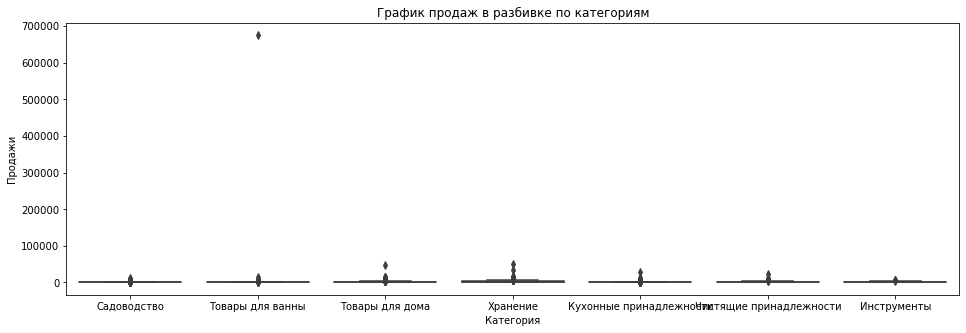

count      5554.000000
mean        830.953262
std        9198.016525
min           9.000000
25%         120.000000
50%         191.000000
75%         734.000000
max      675000.000000
Name: total_price, dtype: float64

In [16]:
# смотрим выбросы в выручке
df_addon['total_price'].describe()
plt.figure(figsize=(16,5))
sns.boxplot(x='purpose_category', y='total_price', data=df_addon)
ax = sns.lineplot()
ax.set_xlabel('Категория')
ax.set_ylabel('Продажи')
ax.set_title('График продаж в разбивке по категориям')
plt.show()
df_addon['total_price'].describe()

Проверим аномальные значения. 

In [17]:
# просмотрим заказы с выбросом
df_addon.query('total_price > 50000')

,date,customer_id,order_id,product,quantity,price,total_price,purpose_category
3797,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,Товары для ванны


Как мы можем заметить всего 1 заказ с такой суммой, думаю такую прибыль можно отнести к разовой. Хотя об этом необходимо сообщить отделу продаж возможно это какой-то оптовый клиент и мы можем получить крупные закупки на постоянной основе. Предлагаю удалить данный заказ, чтобы данные были более объектины.

In [18]:
# очищаем данные от выбросов
df_addon_clean = df_addon.drop(df_addon[df_addon['total_price'] > 100000].index)
#check
# compare_categ_clean = df_addon_clean.pivot_table(index = ['purpose_category'],
#                                       values = ['customer_id', 'total_price'],
#                                       aggfunc = {'customer_id' : 'count', 'total_price' : 'sum'})
# compare_categ_clean.columns = ['count_of_client', 'total']
# compare_categ_clean.sort_values(by = 'total', ascending = False)

In [19]:
# просмотрим кол-во купленных единиц по категориям
count_of_product = df_addon_clean.groupby(['purpose_category']).agg({'quantity':sum}).sort_values(by='quantity', ascending=False)
count_of_product

,quantity
purpose_category,
Садоводство,4615
Товары для дома,2987
Кухонные принадлежности,1703
Хранение,1617
Товары для ванны,1416
Инструменты,647
Чистящие принадлежности,379


- Как мы видим лидеры у нас 2 категории: "Садоводство" и "Товары для дома"

In [20]:
# просмотрим детально по кол-ву купленных товаров
count_of_product = df_addon_clean.groupby(['product']).agg({'quantity':sum}).sort_values(by='quantity', ascending=False)
count_of_product.head(20)

,quantity
product,
Муляж ЯБЛОКО 9 см красное,618
Вешалки мягкие для деликатных вещей 3 шт шоколад,335
"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",201
Муляж Яблоко зеленый 9 см полиуретан,188
"Крепеж для пружины дверной, 1107055",170
Плечики пластмассовые Размер 52 - 54 Тула 1205158,160
"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150
Муляж Банан желтый 21 см полиуретан,109
"Щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096",105


Стоит отметить, что в большом кол-ве покупают товары категории для дома несмотря на лидерство категории "Садоводство". Детализируем категорию "Садоводство" для общего понимания.

In [21]:
# просмотрим детально по кол-ву купленных продуктов в категории "Садоводство"
count_of_plants = df_addon_clean.query('purpose_category == "Садоводство"')
count_of_plants.groupby(['product']).agg({'quantity':sum}).sort_values(by='quantity', ascending=False).head(20)

,quantity
product,
Цветок искусственный Гвоздика пластиковая одиночная в ассортименте 50 см,97
Пеларгония розебудная Red Pandora укорененный черенок,82
"Однолетнее растение Петуния махровая в кассете 4 шт, Россия",78
Пеларгония зональная диам. 12 см сиреневый полумахровый,64
Пеларгония розебудная Prins Nikolai укорененный черенок,63
Пеларгония зональная диам. 12 см красная махровая,63
Цветок искусственный Гвоздика тканевая красная 50 см,49
Пеларгония розебудная Mary укорененный черенок,48
Пеларгония розебудная Margaretha укорененный черенок,47


Ярко выделяются покупки Пеларгония, относится к виду Гераней, как говорит гугл хорошо приживается и проста в уходе и подходит даже для контейнерного садоводства. Неудивительна ее популярность. 

Просмотрим полученные данные по месяцам, для начала выделив номер месяца. 

In [22]:
# добавляем столбец с месяцами
df_addon_clean['month'] = df_addon_clean['date'].astype('datetime64[M]')

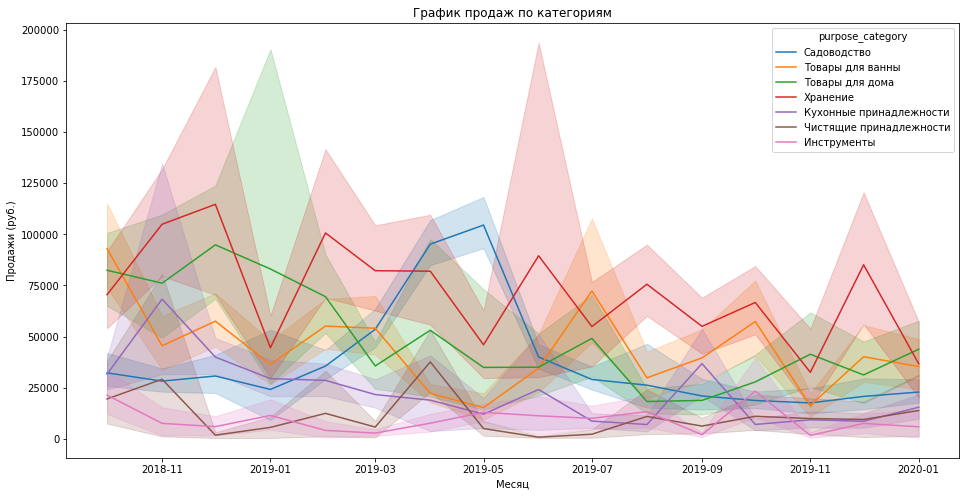

In [23]:
# просмотрим график выручки по месяцам
plt.figure(figsize=(16,8))
sns.lineplot(x='month', y='total_price', hue='purpose_category', data=df_addon_clean, estimator='sum')
ax = sns.lineplot()
ax.set_xlabel('Месяц')
ax.set_ylabel('Продажи (руб.)')
ax.set_title('График продаж по категориям')
plt.show()

- Как можем заметить каких-то резких выбросов, после удаления вантузов мы не замечаем
- С февраля начинается подъем спроса на категорию товаров "Садоводство" вплоть до середины лета
- "Хранение" показывает стальный спрос в течение года 
- Странно, что спрос на категорию "Товары для дома" был с октября 2018 года по январь 2019 года, однако мы не наблюдаем такого роста с октября 2019 года до января 2020 года

In [24]:
# просматриваем по кол-ву заказов
count_of_product = df_addon_clean.groupby(['purpose_category']).agg({'order_id':'count'}).sort_values(by='order_id', ascending=False)
count_of_product.head(20)

,order_id
purpose_category,
Садоводство,2880
Товары для дома,738
Товары для ванны,704
Хранение,563
Кухонные принадлежности,454
Чистящие принадлежности,109
Инструменты,105


In [25]:
# формируем сводные данные по кол-ву заказов в течение года 
order_of_year = pd.pivot_table(df_addon_clean, index=['month'], values=['order_id'], aggfunc='count')
order_of_year

,order_id
month,
2018-10-01,479
2018-11-01,430
2018-12-01,308
2019-01-01,185
2019-02-01,361
2019-03-01,412
2019-04-01,674
2019-05-01,689
2019-06-01,330


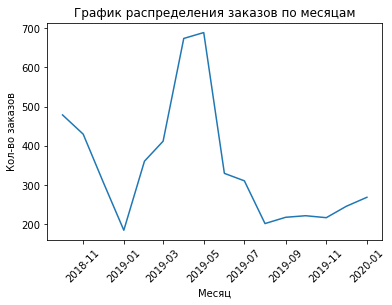

In [26]:
# строим график по данным 
plt.plot(order_of_year)
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Кол-во заказов')
plt.title('График распределения заказов по месяцам')
plt.show()

- Отметим следующее: 
  - Пик заказов приходится на весеннее время, как мы понимаем ввиду того, что в это время идет посевная
  - Зимние месяцы 2018 года показали большее кол-во заказов в сравнение с 2019 годом
  - Январь 2020 года показал чуть лучшую динамику в сравнении с 2019 годом

Проверим есть ли клиенты которые заказывали аномально много. 

In [27]:
# просматриваем по кол-ву заказов на клиента
count_of_client = df_addon_clean.groupby(['customer_id']).agg({'order_id':'count'})
count_of_client.sort_values(by='order_id', ascending=False).head(10)

,order_id
customer_id,
c971fb21-d54c-4134-938f-16b62ee86d3b,143
d3b9ffea-d143-4747-8d59-74ab843d1ad6,51
4d93d3f6-8b24-403b-a74b-f5173e40d7db,45
760aa067-90c3-4794-b7a9-a8831197388b,36
2a0acc09-e343-4f92-b5c0-f598ef2b07d4,31
3d5fef90-4a65-4a7e-84cf-010eba7b038d,30
1420716a-02ef-426f-828d-fddcb0e1f532,30
a3394ff2-4cd2-4332-9f6c-2668ac608fbc,30
0184f535-b60a-4914-a982-231e3f615206,30


Как мы можем заметить, что в данных присутствует клиент с аномально крупным числом заказов относительно других, удалим его из данных чтобы не было искажений и передадим информацию о нем в отдел продаж. 

In [28]:
df_addon_clean = df_addon_clean.drop(df_addon_clean[df_addon_clean['customer_id'] == 'c971fb21-d54c-4134-938f-16b62ee86d3b'].index)

In [29]:
# check
# count_of_client = df_addon_clean.groupby(['customer_id']).agg({'order_id':'count'})
# count_of_client.sort_values(by='order_id', ascending=False).head(10)

In [30]:
# создадим уникальные пары с датой, когда был совершён заказ и категориями товаров
datesGroups = df_addon_clean[['date', 'purpose_category']].drop_duplicates()

Далее, как и планировали просмотрим кумулятивную выручку и кумулятивный средний чек и составим предварительный портрет покупателя, чтобы далее кластеризовать. 

In [31]:
# найдем сумму выручки по группам с уникальными id и датами.
priceAggregated = datesGroups.apply(
    lambda x: df_addon_clean[np.logical_and(df_addon_clean['date'] <= x['date'], df_addon_clean['purpose_category'] == x['purpose_category'])].agg({
'date' : 'max',
'purpose_category' : 'max',
'order_id' : pd.Series.nunique,
'customer_id' : pd.Series.nunique,
'total_price' : 'sum'}), axis=1).sort_values(by=['date','purpose_category'])

In [32]:
# добавим кол-во продукции
productAggregated = datesGroups.apply(
    lambda x: df_addon_clean[np.logical_and(df_addon_clean['date'] <= x['date'], df_addon_clean['purpose_category'] == x['purpose_category'])].agg({
'date' : 'max', 
'purpose_category' : 'max',
'quantity' : 'sum'}), axis=1).sort_values(by=['date','purpose_category'])

In [33]:
# объединяем данные и сформируем графики
cumulativeData = priceAggregated.merge(productAggregated, left_on=['date', 'purpose_category'], right_on=['date', 'purpose_category'])
cumulativeData.columns = ['date', 'category', 'orders', 'customers', 'total_price', 'quantity']
# cumulativeData.head(5) # check

- Получили таблицу для каждой категории клиентов со следующими данными:
  - Дата (date)
  - Категория товаров (category)
  - Кумулятивное количество заказов (orders)
  - Кумулятивное количество клиентов (customers)
  - Кумулятивная выручка (total_price)
  - Кумулятивное количество единиц (quantity)

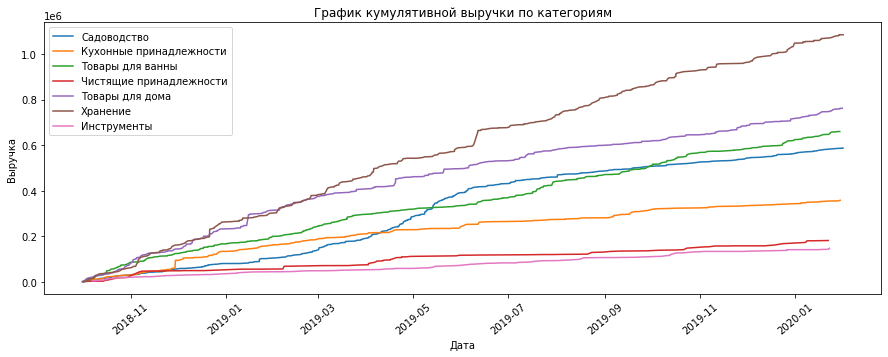

In [34]:
# датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в категориях товаров
cumulativeRevenueG = cumulativeData[cumulativeData['category']=='Садоводство'][['date','total_price', 'orders', 'customers', 'quantity']]
cumulativeRevenueD = cumulativeData[cumulativeData['category']=='Кухонные принадлежности'][['date','total_price', 'orders', 'customers', 'quantity']]
cumulativeRevenueB = cumulativeData[cumulativeData['category']=='Товары для ванны'][['date','total_price', 'orders', 'customers', 'quantity']]
cumulativeRevenueC = cumulativeData[cumulativeData['category']=='Чистящие принадлежности'][['date','total_price', 'orders', 'customers', 'quantity']]
cumulativeRevenueH = cumulativeData[cumulativeData['category']=='Товары для дома'][['date','total_price', 'orders', 'customers', 'quantity']]
cumulativeRevenueS = cumulativeData[cumulativeData['category']=='Хранение'][['date','total_price', 'orders', 'customers', 'quantity']]
cumulativeRevenueT = cumulativeData[cumulativeData['category']=='Инструменты'][['date','total_price', 'orders', 'customers', 'quantity']]

# строим графики выручки групп А и В
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(cumulativeRevenueG['date'], cumulativeRevenueG['total_price'], label= 'Садоводство')
plt.plot(cumulativeRevenueD['date'], cumulativeRevenueD['total_price'], label= 'Кухонные принадлежности')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['total_price'], label= 'Товары для ванны')
plt.plot(cumulativeRevenueC['date'], cumulativeRevenueC['total_price'], label= 'Чистящие принадлежности')
plt.plot(cumulativeRevenueH['date'], cumulativeRevenueH['total_price'], label= 'Товары для дома')
plt.plot(cumulativeRevenueS['date'], cumulativeRevenueS['total_price'], label= 'Хранение')
plt.plot(cumulativeRevenueT['date'], cumulativeRevenueT['total_price'], label= 'Инструменты')
plt.xticks(rotation=40)
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.title('График кумулятивной выручки по категориям')


plt.legend()
plt.show()

Как мы можем заметить, что наши лидеры в данном случае это - "Хранение" и "Товары для дома" и это не удивительно ведь данные категории значительно перекликаются, т.к ящики, банки и тому подобное у нас находятся в категории хранение и постоянно перекликаются. Можем заметить, как происходит резкий подъем категории садоводство ближе к маю.

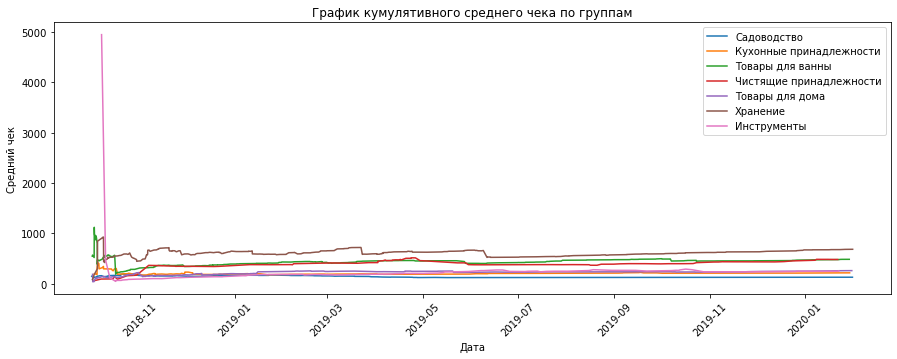

In [35]:
# получаем график кумулятивного среднего чека
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(cumulativeRevenueG['date'], cumulativeRevenueG['total_price'] / cumulativeRevenueG['quantity'], label= 'Садоводство')
plt.plot(cumulativeRevenueD['date'], cumulativeRevenueD['total_price'] / cumulativeRevenueD['quantity'], label= 'Кухонные принадлежности')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['total_price'] / cumulativeRevenueB['quantity'], label= 'Товары для ванны')
plt.plot(cumulativeRevenueC['date'], cumulativeRevenueC['total_price'] / cumulativeRevenueC['quantity'], label= 'Чистящие принадлежности')
plt.plot(cumulativeRevenueH['date'], cumulativeRevenueH['total_price'] / cumulativeRevenueH['quantity'], label= 'Товары для дома')
plt.plot(cumulativeRevenueS['date'], cumulativeRevenueS['total_price'] / cumulativeRevenueS['quantity'], label= 'Хранение')
plt.plot(cumulativeRevenueT['date'], cumulativeRevenueT['total_price'] / cumulativeRevenueT['quantity'], label= 'Инструменты')

plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Средний чек")
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.show()

В начале были выбросы по среднему чеку, особенно в категории "Инструменты", однако потом средний чек выровнялся во всех категориях и заметно выделялась только категория "Хранение".

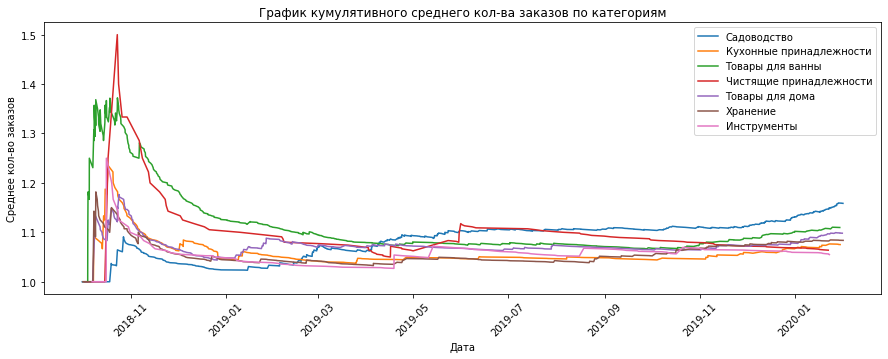

In [36]:
# получаем график кумулятивного среднего кол-ва заказов для категорий
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(cumulativeRevenueG['date'], cumulativeRevenueG['orders'] / cumulativeRevenueG['customers'], label= 'Садоводство')
plt.plot(cumulativeRevenueD['date'], cumulativeRevenueD['orders'] / cumulativeRevenueD['customers'], label= 'Кухонные принадлежности')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['orders'] / cumulativeRevenueB['customers'], label= 'Товары для ванны')
plt.plot(cumulativeRevenueC['date'], cumulativeRevenueC['orders'] / cumulativeRevenueC['customers'], label= 'Чистящие принадлежности')
plt.plot(cumulativeRevenueH['date'], cumulativeRevenueH['orders'] / cumulativeRevenueH['customers'], label= 'Товары для дома')
plt.plot(cumulativeRevenueS['date'], cumulativeRevenueS['orders'] / cumulativeRevenueS['customers'], label= 'Хранение')
plt.plot(cumulativeRevenueT['date'], cumulativeRevenueT['orders'] / cumulativeRevenueT['customers'], label= 'Инструменты')

plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во заказов')
plt.title('График кумулятивного среднего кол-ва заказов по категориям')
plt.legend()
plt.show()

Опять резкие скачки в начале с дальнейшей стагнацией. Однако стоит отметить, как со временем себя хорошо показывает категория "Садоводство", которая по итогу показывает лучший рез-тат. 

#### Вывод

- Сформированы предварительные выводы касательно клиентов: 
  - Наибольшее кол-во клиентов приходится на категорию "Садоводство", однако оно не дает большое кол-во выручки ввиду сезонности, что видно из полученных графиков
  - Наибольшую прибыль приносят 2 неразрывных категории: "Хранение" и "Товары для дома"
  - Периодически мы имеем выбросы, что видно по выручке и среднему чеку, это могут оптовые закупки, необходимо проработать этих клиентов
  - Под конец лета у нас большой обвал в заказах, думаю стоит обратить наше внимение, как раз на категорию хранение, т.к, как раз начинается уборка урожая и закрутка банок

### Кластеризацию клиентов.

Как и планировали для начала сформируем данные по айди клиента.

In [37]:
# сгруппируем и объединим новый датасет
gr_table_up = df_addon_clean.groupby(['customer_id', 'order_id']).agg({'product':'count', 'quantity':'sum', 'total_price':'sum', 'price':'mean'}).reset_index()
gr_table_update = gr_table_up.groupby('customer_id').agg({'order_id':'nunique', 'product':'sum', 'quantity':'mean', 'price':'mean', 'total_price':'mean',}).reset_index()
gr_table_update.columns = ['customer_id', 'order_id', 'product', 'quantity', 'price', 'total_price']

In [38]:
# check
# gr_table_update

In [39]:
# стандартизируем данные 
df_cl = gr_table_update.drop(['customer_id'], axis=1)
gr_table_column = df_cl.columns
df_cl = StandardScaler().fit_transform(df_cl)
df_cl = pd.DataFrame(df_cl, columns = gr_table_column).astype('float64')

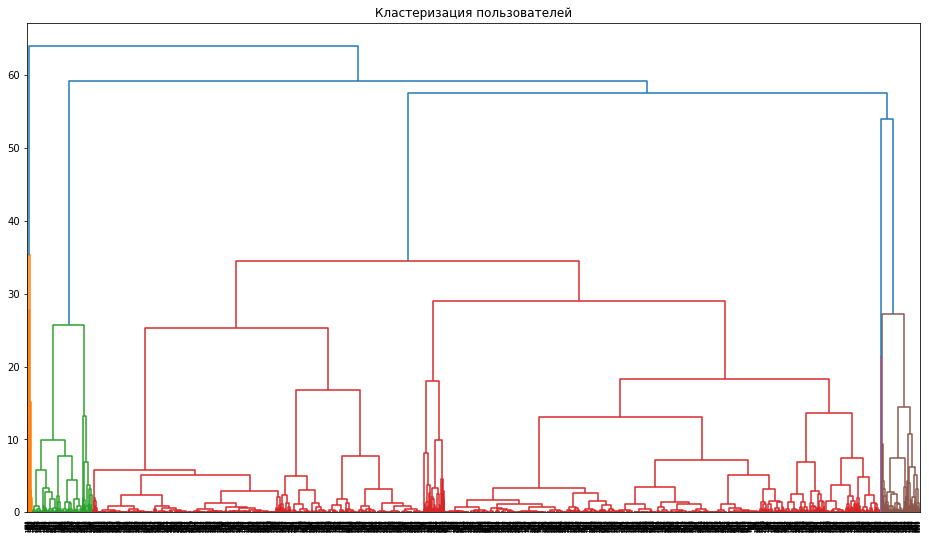

In [40]:
# строим матрицу расстояний, на стандартизованной матрице признаков и рисуем дендрограмму
link = linkage(df_cl, method = 'ward')
plt.figure(figsize=(16, 9))  
dendrogram(link, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

In [41]:
# обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
km = KMeans(n_clusters = 4, random_state = 42)
labels = km.fit_predict(df_cl)
gr_table_update['cluster'] = labels

In [42]:
# сравним кластеры по средним значениям
gr_table_update.groupby('cluster').mean().T

cluster,0,1,2,3
order_id,1.395833,2.547170,1.000000,1.372125
product,1.473958,20.226415,1.666667,1.858326
quantity,2.117622,19.716532,194.666667,3.623352
price,3388.332465,161.731172,125.962963,493.500712
total_price,4332.184028,2283.085236,18378.888889,792.955018


In [43]:
# просмотрим распределение кластеризации 
gr_table_update.cluster.value_counts()

3    2174
0     192
1      53
2       9
Name: cluster, dtype: int64

In [44]:
# получаем обновленную таблицу с кластерами
df_addon_clean = df_addon_clean.merge(gr_table_update[['customer_id', 'cluster']], how='left', on='customer_id')
df_addon_clean_cl = df_addon_clean.groupby(['cluster', 'purpose_category', 'month']).agg({'order_id':'count'}).reset_index()

In [45]:
 # Просмотрим распределение по кол-ву заказов и выручке 
df_addon_clean_rev = df_addon_clean.pivot_table(index='purpose_category', columns='cluster', aggfunc={'total_price':'sum', 'order_id':'count'})
df_addon_clean_rev

order_id                     total_price            \
cluster                        0      1    2       3           0         1   
purpose_category                                                             
Инструменты                 18.0    3.0  1.0    79.0     65638.0    8723.0   
Кухонные принадлежности     16.0   27.0  6.0   391.0     50361.0    9411.0   
Садоводство                 22.0  940.0  NaN  1886.0     40875.0  120717.0   
Товары для ванны            46.0   27.0  1.0   593.0    145187.0   30287.0   
Товары для дома             53.0   51.0  4.0   598.0    240328.5   21876.0   
Хранение                   111.0   17.0  3.0   410.0    495913.5   23283.0   
Чистящие принадлежности     17.0    7.0  NaN    83.0     98332.0   14522.0   

                                                 
cluster                        2              3  
purpose_category                                 
Инструменты               2850.0   69987.333333  
Кухонные принадлежности  33680.0  264692.000000  
Садоводство                  NaN  425689.333333  
Товары для ванны          5700.0  478659.000000  
Товары для дома          38030.0  461710.500000  
Хранение                 85150.0  480285.750000  
Чистящие принадлежности      NaN   68718.500000

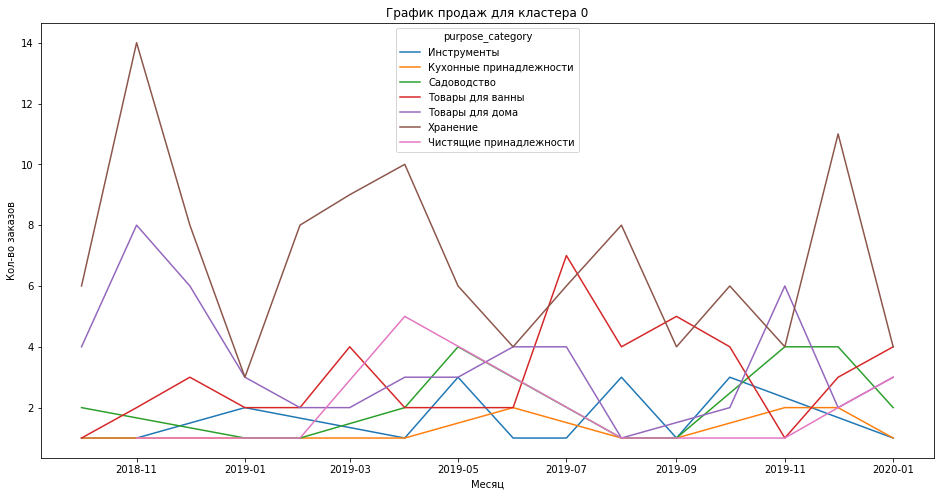

In [46]:
# просмотрим кол-во покупок по месяцам для кластера 0
plt.figure(figsize=(16,8))
sns.lineplot(x='month', y='order_id', hue='purpose_category', data=df_addon_clean_cl.query('cluster == 0'), estimator='sum')
ax = sns.lineplot()
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во заказов')
ax.set_title('График продаж для кластера 0')
plt.show()

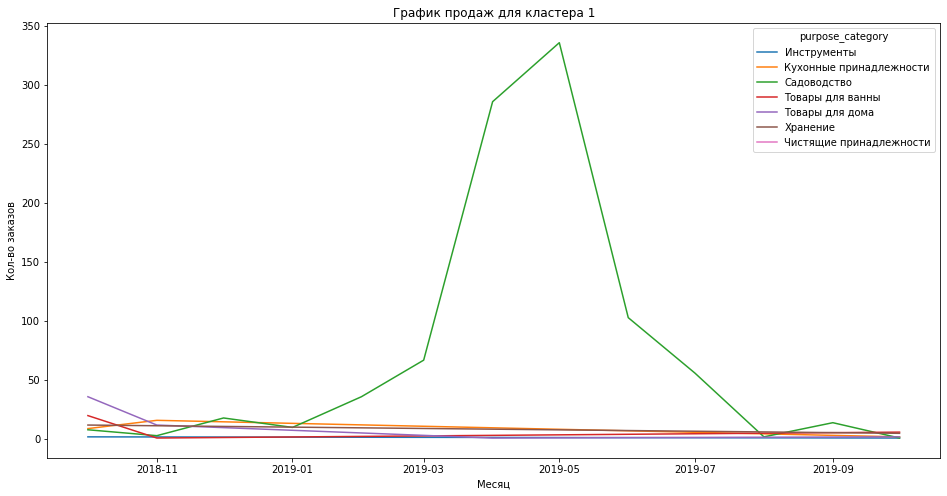

In [47]:
# просмотрим кол-во покупок по месяцам для кластера 1
plt.figure(figsize=(16,8))
sns.lineplot(x='month', y='order_id', hue='purpose_category', data=df_addon_clean_cl.query('cluster == 1'), estimator='sum')
ax = sns.lineplot()
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во заказов')
ax.set_title('График продаж для кластера 1')
plt.show()

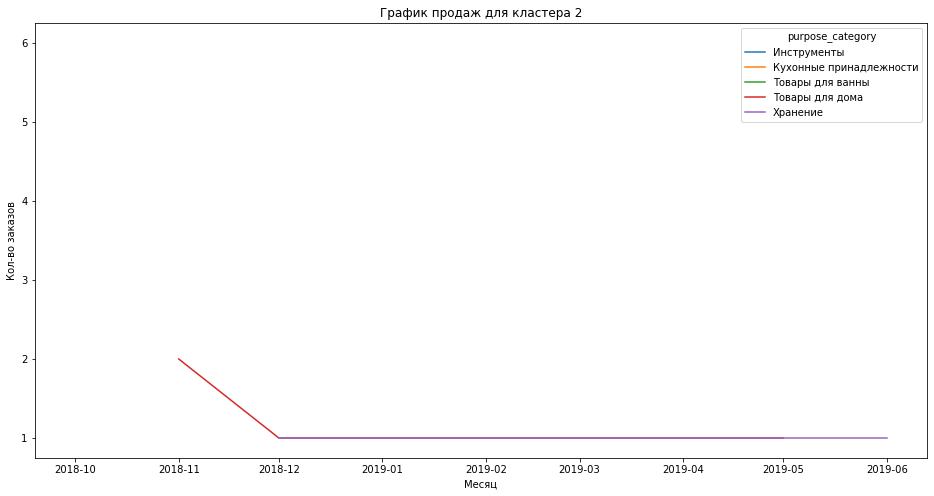

In [48]:
# просмотрим кол-во покупок по месяцам для кластера 2
plt.figure(figsize=(16,8))
sns.lineplot(x='month', y='order_id', hue='purpose_category', data=df_addon_clean_cl.query('cluster == 2'), estimator='sum')
ax = sns.lineplot()
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во заказов')
ax.set_title('График продаж для кластера 2')
plt.show()

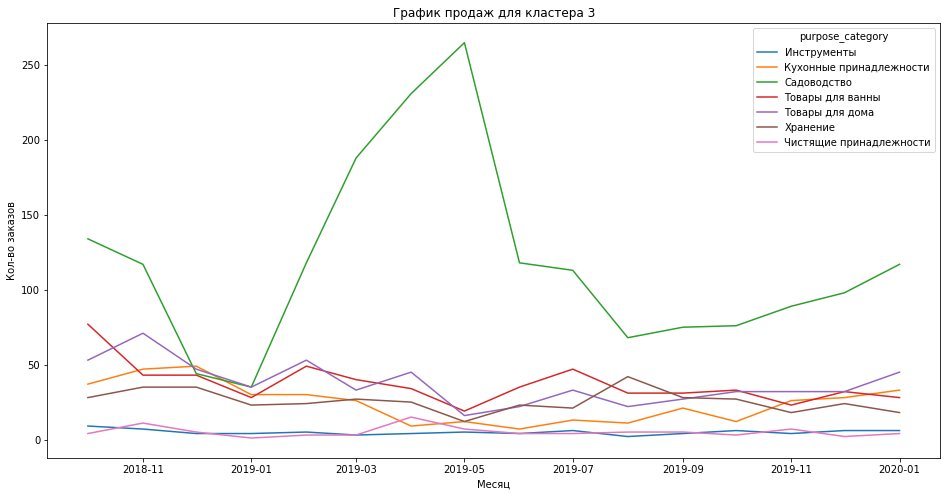

In [49]:
# просмотрим кол-во покупок по месяцам для кластера 3
plt.figure(figsize=(16,8))
sns.lineplot(x='month', y='order_id', hue='purpose_category', data=df_addon_clean_cl.query('cluster == 3'), estimator='sum')
ax = sns.lineplot()
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во заказов')
ax.set_title('График продаж для кластера 3')
plt.show()

#### Вывод

- Отметим, что получено по итогу:
  - Наиболее многочисленный кластер - 3 (2174 кл.), который делает 1-2 заказа, со средним чеком до 500 руб. и общими тратами в среднем до 800 руб. Наибольшее кол-во заказов приходится на категорию "Садоводство" - 1886 заказов, а также примерно поровну "Товары для ванны" - 593 и "Товары для дома" - 598. Однако наибольшую прибыль приносит категория "Хранение" =  480285 руб.
  - 0й кластер включает в себя 192 клиента, совершающих в среднем 2 заказа, со средним чеком до 3400 руб. и средними общими тратами до 4400 руб. Наиболее востребованы у этих клиентов следующие категории товаров: "Хранение" - 111 заказов, "Товары для дома" - 53 заказа, "Товары для ванны" - 46 заказов, наибольшу прибыль так же, как в 3й категории приносит категория "Хранение" - 495913, далее следуют "Товары для дома" - 240328 и "Товары для ванны" - 145187. 
  - 1й кластер включает в себя 53 клиента которые совершают в среднем 2-3 заказа, со средним чеком - 161 руб, однако ввиду того, что зачастую покупают большое кол-во товаров, в среднем 20, то максимальные прибыли доходят до 2200. Наиболее предпочтительная категория для данных клиентов "Садоводство" в которой было аж 940 заказов с прибылью 120717 руб.
  - 2й кластер наименьший - 9 клиентов. Совершающий в среднем 1 заказ, средний чек - 125, однако масимальная прибыль в среднем 18300 (ввиду маленього кол-во заказов такой разброс данных). Наибольшую прибыль приносит категория "Хранение" - 85150 руб. 

### Проверка гипотез.

In [50]:
# Посчитаем среднее, дисперсию и стандартное отклонение.
gyp_table = gr_table_update.pivot_table(index = ['cluster'], values = ['price', 'total_price'],
                                            aggfunc = {'price' : [np.median, np.var, np.std, np.mean],
                                                      'total_price' : [np.median, np.var, np.std, np.mean]})
gyp_table = round(gyp_table, 2)
gyp_table

price                               total_price                     \
            mean   median      std         var        mean   median       std   
cluster                                                                         
0        3388.33  2929.75  1686.79  2845254.31     4332.18  3524.00   3137.38   
1         161.73   118.23   207.41    43020.58     2283.09  1636.51   2971.55   
2         125.96    51.00   176.53    31162.87    18378.89  8670.00  16207.67   
3         493.50   299.50   485.58   235786.49      792.96   562.00    786.15   

                       
                  var  
cluster                
0        9.843159e+06  
1        8.830127e+06  
2        2.626887e+08  
3        6.180386e+05

При медиане меньше чем среднее и достаточно большому стандартному отклонению можем с уверенностью сказать, что данные скошены вправо. Как мы поняли в наших данных есть выбросы в связи с этим на мой взгляд для проверки сформированных гипотез подойдет тест Уилкоксона-Манна-Уитни, который проранжирует обе выборки и сравнит их ранги. Для проверки гипотез мы возьмем 2 наших основных кластера и сравним их среднюю прибыль и средний чек. 

- Проверим статистическую значимость различий между кластерами сформируем гипотезы
  - H0 - Разница в среднем чеке между кластерами отсутствует 
  - H1 - Разница в среднем чеке между кластерами имеет значительные различия
  - alpha = 0.05

In [51]:
# просматриваем разницу в среднем чеке между 0м кластером и 1м
alpha = 0.05
zero_one = st.mannwhitneyu(gr_table_update.query('cluster == 0')['price'], gr_table_update.query('cluster == 1')['price'])[1]
print('p-value: ', zero_one)
if zero_one < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в среднем чеке между кластерами отсутствует'
    )

p-value:  1.3439518588420719e-28
Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия


In [52]:
# просматриваем разницу в среднем чеке между 0м и 2м кластером
alpha = 0.05
zero_two = st.mannwhitneyu(gr_table_update.query('cluster == 0')['price'], gr_table_update.query('cluster == 2')['price'])[1]
print('p-value: ', zero_two)
if zero_two < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в среднем чеке между кластерами отсутствует'
    )

p-value:  4.6469516895316805e-07
Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия


In [53]:
# просматриваем разницу в среднем чеке между 0м и 3м кластером
alpha = 0.05
zero_three = st.mannwhitneyu(gr_table_update.query('cluster == 0')['price'], gr_table_update.query('cluster == 3')['price'])[1]
print('p-value: ', zero_three)
if zero_three < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в среднем чеке между кластерами отсутствует'
    )

p-value:  5.996903631191469e-111
Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия


In [54]:
# просматриваем разницу в среднем чеке между 1м и 2м кластерам
alpha = 0.05
one_two = st.mannwhitneyu(gr_table_update.query('cluster == 1')['price'], gr_table_update.query('cluster == 2')['price'])[1]
print('p-value: ', one_two)
if one_two < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в среднем чеке между кластерами отсутствует'
    )

p-value:  0.0838852048143944
Не получилось отвергнуть нулевую гипотезу: разница в среднем чеке между кластерами отсутствует


In [55]:
# просматриваем разницу в среднем чеке между 1м и 3м кластером
alpha = 0.05
one_three = st.mannwhitneyu(gr_table_update.query('cluster == 1')['price'], gr_table_update.query('cluster == 3')['price'])[1]
print('p-value: ', one_three)
if one_three < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в среднем чеке между кластерами отсутствует'
    )

p-value:  3.3610304101196605e-10
Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия


In [56]:
# просматриваем разницу в среднем чеке между 2м и 3м кластером
alpha = 0.05
two_three = st.mannwhitneyu(gr_table_update.query('cluster == 2')['price'], gr_table_update.query('cluster == 3')['price'])[1]
print('p-value: ', two_three)
if two_three < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в среднем чеке между кластерами отсутствует'
    )

p-value:  0.0010388319207117267
Отвергаем нулевую гипотезу: разница в среднем чеке между кластерами имеет значительные различия


- Проверим статистическую значимость различий между кластерами сформируем гипотезы
  - H0 - Разница в средней выручке между кластерами отсутствует 
  - H1 - Разница в средней выручке между кластерами имеет значительные различия
  - alpha = 0.05

In [57]:
# просматриваем разницу в средней выручке между 0м и 1м кластером
alpha = 0.05
zero_one_rev = st.mannwhitneyu(gr_table_update.query('cluster == 0')['total_price'], gr_table_update.query('cluster == 1')['total_price'])[1]
print('p-value: ', zero_one_rev)
if zero_one_rev < alpha:
    print('Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в средней выручке между кластерами отсутствует'
    )

p-value:  9.89459733420398e-16
Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия


In [58]:
# просматриваем разницу в средней выручке между 0м и 2м кластером
alpha = 0.05
zero_two_rev = st.mannwhitneyu(gr_table_update.query('cluster == 0')['total_price'], gr_table_update.query('cluster == 2')['total_price'])[1]
print('p-value: ', zero_two_rev)
if zero_two_rev < alpha:
    print('Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в средней выручке между кластерами отсутствует'
    )

p-value:  8.027839564858256e-05
Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия


In [59]:
# просматриваем разницу в средней выручке между 0м и 3м кластером
alpha = 0.05
zero_three_rev = st.mannwhitneyu(gr_table_update.query('cluster == 0')['total_price'], gr_table_update.query('cluster == 3')['total_price'])[1]
print('p-value: ', zero_three_rev)
if zero_three_rev < alpha:
    print('Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в средней выручке между кластерами отсутствует'
    )

p-value:  5.055663969709114e-109
Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия


In [60]:
# просматриваем разницу в средней выручке между 1м и 2м кластером
alpha = 0.05
one_two_rev = st.mannwhitneyu(gr_table_update.query('cluster == 1')['total_price'], gr_table_update.query('cluster == 2')['total_price'])[1]
print('p-value: ', one_two_rev)
if one_two_rev < alpha:
    print('Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в средней выручке между кластерами отсутствует'
    )

p-value:  6.918521584440131e-06
Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия


In [61]:
# просматриваем разницу в средней выручке между 1м и 3м кластером
alpha = 0.05
one_three_rev = st.mannwhitneyu(gr_table_update.query('cluster == 1')['total_price'], gr_table_update.query('cluster == 3')['total_price'])[1]
print('p-value: ', one_three_rev)
if one_three_rev < alpha:
    print('Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в средней выручке между кластерами отсутствует'
    )

p-value:  4.773040912585095e-18
Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия


In [62]:
# просматриваем разницу в средней выручке между 2м и 3м кластером
alpha = 0.05
two_three_rev = st.mannwhitneyu(gr_table_update.query('cluster == 2')['total_price'], gr_table_update.query('cluster == 3')['total_price'])[1]
print('p-value: ', two_three_rev)
if two_three_rev < alpha:
    print('Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: разница в средней выручке между кластерами отсутствует'
    )

p-value:  2.48094294629306e-07
Отвергаем нулевую гипотезу: разница в средней выручке между кластерами имеет значительные различия


In [63]:
# получим очищенные данные для создания дашборда
df_addon_clean.to_csv('E-commerce.csv', index=False)
df_addon_clean.head(10)

,date,customer_id,order_id,product,quantity,price,total_price,purpose_category,month,cluster
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,Садоводство,2018-10-01,3
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,Садоводство,2018-10-01,3
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,Садоводство,2018-10-01,3
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,Садоводство,2018-10-01,3
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,Садоводство,2018-10-01,3
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,164.0,Садоводство,2018-10-01,3
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,134.0,Садоводство,2018-10-01,3
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,824.0,Товары для ванны,2018-10-01,3
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0,269.0,Товары для ванны,2018-10-01,3
9,2018-10-01 11:00:00,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,68483,Вешалка для брюк металлическая с резиновым пок...,10,82.0,820.0,Хранение,2018-10-01,3


#### Вывод

 - В среднем чеке между кластерами существуют значительные различия в среднем чеке, что подтверждает ранее полученные нами данные за исключением между 2м и 3м кластерами, думаю в данном случае это может быть связано с тем, что во второй категории очень большой разброс при среднем чеке в 125 руб. максимальная выручка доходит до 18Т
 
- В средней выручке подтверждаются наши данные о существенной разнице в выручке между кластерами. 

### Общий вывод.

Нашей задачей было проведение сегментации клиентов интернет-магазина товаров для дома и быта «Пока все ещё тут», основываясь на данных их покупок чтобы в дальнейшем провести информационную рассылку. В рамках исследования клиенты разделены на кластеры на основании которых даны рекомендации. 
  
__Кластер №0__
 - 192 клиента 
   - Клиенты совершали покупки в следующих категориях: 
     - "Инструменты" - 65638 руб.
     - "Кухонные принадлежности" - 50361 руб.
     - "Садоводство" - 40875 руб.
     - "Товары для ванны" - 145187 руб.
     - "Товары для дома" - 240328 руб.
     - "Хранение" - 495913 руб.
     - "Чистящие принадлежности" - 98332 руб.
   - Данные клиенты совершают в среднем 1-2 заказа
   - Покупают в среднем 2 продукта в кол-ве 2 ед. 
   - Средний чек - 3388 руб.
   - Максимальные траты доходяь до 4332 руб.
   - По кол-ву заказов в категориях: 
     - "Инструменты" - 18
     - "Кухонные принадлежности" - 16
     - "Садоводство" - 22
     - "Товары для ванны" - 46
     - "Товары для дома" - 53
     - "Хранение" - 111
     - "Чистящие принадлежности" - 17 
- Рекомендации: Исходя из графиков продаж в течение года на мой взгляд для данного кластера необходимо в период ноябрь-январь проводить промо продвижение товаров для дома и хранения, так же в этот период можно делать скидки на категории товаров "Инструменты" чтобы увеличить низкий спрос на эту категорию платежеспособных клиентов, либо ввести накопительную систему балов. 

__Кластер №1__
 - 53 клиента 
   - Клиенты совершали покупки в следующих категориях: 
      - "Инструменты" - 8723 руб.
      - "Кухонные принадлежности" - 9411 руб.
      - "Садоводство" - 120717 руб.
      - "Товары для ванны" - 30287 руб.
      - "Товары для дома" - 21876 руб.
      - "Хранение" - 23283 руб.
      - "Чистящие принадлежности" - 14522 руб.
   - Данные клиенты совершают в среднем 2-3 заказа
   - Покупают в среднем 20 продуктов 
   - Средний чек - 161 руб.
   - Максимальные траты доходят до 2283 руб.
   - По кол-ву заказов в категориях: 
     - "Инструменты" - 3
     - "Кухонные принадлежности" - 27
     - "Садоводство" - 940
     - "Товары для ванны" - 27
     - "Товары для дома" - 51
     - "Хранение" - 17
     - "Чистящие принадлежности" - 7
- Рекомендации: Как мы можем заметить в этом кластере значительно превалирует категория товаров "Садоводство" (940 заказов), пик заказов приходится с января по май. Скорее всего типичный потребиль данного кластера дачники и к концу лета когда их интерес падает к "Садоводство" мы можем начинать продвигать прибыльную категорию "Хранение" в которую входят к примеру банки необходимые для заготовок к примеру смс рассылкой.

__Кластер №2__
 - 9 клиентов
   - Клиенты совершали покупки в следующих категориях: 
      - "Инструменты" - 2850 руб.
      - "Кухонные принадлежности" - 33680 руб.
      - "Садоводство" - 0 руб.
      - "Товары для ванны" - 5700 руб.
      - "Товары для дома" - 38030 руб.
      - "Хранение" - 85150 руб.
      - "Чистящие принадлежности" - 0 руб.
   - Данные клиенты совершают в среднем 1 заказ
   - Покупают в среднем 2 продукта 
   - Средний чек - 125 руб.
   - Максимальные траты доходят до 18378 руб.
   - По кол-ву заказов в категориях: 
     - "Инструменты" - 1
     - "Кухонные принадлежности" - 6
     - "Садоводство" - 0
     - "Товары для ванны" - 1
     - "Товары для дома" - 4
     - "Хранение" - 3
     - "Чистящие принадлежности" - 0
- Рекомендации: Как мы можем заметить по графику клиенты данного кластера совершали в среднем одну покупку и уходили от нас. Думаю данных клиентов необходимо передать в отдел продаж, чтобы они выяснили возможно у клиентов возникли какие-то проблемы с нашим сервисом и их можно вернуть. 
 
     
__Кластер №3__
 - 2174 клиента 
   - Клиенты совершали покупки в следующих категориях: 
      - "Инструменты" - 69987 руб.
      - "Кухонные принадлежности" - 264692 руб.
      - "Садоводство" - 425689 руб.
      - "Товары для ванны" - 478659 руб.
      - "Товары для дома" - 461710 руб.
      - "Хранение" - 480285 руб.
      - "Чистящие принадлежности" - 68718 руб.
   - Данные клиенты совершают в среднем 1-2 заказа
   - Покупают в среднем 2 продукта в кол-ве 3 ед. 
   - Средний чек - 493 руб.
   - Максимальные траты доходяь до 792 руб.
   - По кол-ву заказов в категориях: 
     - "Инструменты" - 79
     - "Кухонные принадлежности" - 391
     - "Садоводство" - 1886
     - "Товары для ванны" - 593
     - "Товары для дома" - 598
     - "Хранение" - 410
     - "Чистящие принадлежности" - 83
- Рекомендации: Самый многочисленный и прибыльный кластер. Самая популярная категория товаров в данном кластере "Садоводство" показывает стабильно высокий спрос в период с января по июль, с дальнейшим ростом ближе ноябрю. На мой взгляд для это категории необходимо подогревать интерес к категории "Хранение", т.к мы видим меньший интерес по сравнению с категорией "товары для дома" 410 против 598, а это наша самая прибыльная категория, считаю, что промо надо начинать в августе. 

__Оптовые клиенты__
 - Так же во время исследования мы выявили клиентов соверщающих закупки либо 1000 единиц, либо совершающих более 100 заказов, таких клиентов надо отслеживать, вдруг есть спрос и мы сможем увеличить кол-во оптовых клиентов к примеру расширением матрицы товаров. 

https://public.tableau.com/app/profile/tim21051960/viz/E-commerce_ByninTimur_12DA/Dashboard1?publish=yes ссылка на Дашборд